In [16]:
# CartPole-v1 using Q-learning

import gym
import cartpole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Linear regression
from sklearn.linear_model import LinearRegression

from collections import deque

import random

from tensorflow import keras

from tqdm import tqdm

import multiprocessing

import time

sns.set_style("darkgrid")

# Q-Table 

This method will be used for the 2 environment

In [17]:
#Define the Q table and the bins

#Define a discret Qtable
def Qtable(state_space,action_space,bin_size = 30):
    # Values seem to be arbitrary
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

#Define a function to discretize the state
def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

# Learning from an environment using a Discrete Q-Table

In [18]:
def Q_learning(env, q_table, bins, episodes = 1000, gamma = 0.95, learning_rate = 0.1, timestep = 100, exploration = 0.8, exploration_decay = 0.9995, tqdm_disable = False):
    rewards = 0
    steps = 0

    # For plotting - metrics to track the performance
    scores = []
    steps_history = []
    exploration_list = []

    for episode in tqdm(range(1,episodes+1), disable = tqdm_disable):
        # env.reset() => initial observation
        current_state = Discrete(env.reset(),bins)
      
        score = 0
        done = False
        while not done: 
            steps+=1
            #if episode%timestep==0: env.render()
            if np.random.uniform(0,1) < exploration: # Exploration
                action = env.action_space.sample()
            else: # Exploitation
                action = np.argmax(q_table[current_state])
            observation, reward, done, info = env.step(action)
            next_state = Discrete(observation,bins)
            score+=reward
          
            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-learning_rate)*current_q + learning_rate*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q
            current_state = next_state
            
            
        
        # End of the loop update
        else:
            rewards += score
            exploration = max(exploration*exploration_decay,0.05) # Exploration decay to exploit more and more the model
            #if score > 195 and steps >= 100: print(f'steps {steps}Solved') #May help to identify during the training if the model sucesses
        if episode % timestep == 0: 
            #print(rewards / timestep)
            scores.append(rewards/timestep)
            steps_history.append(steps/timestep)
            exploration_list.append(exploration)
            steps=0
            rewards = 0 #Average score over 100 episodes
    
    return q_table, scores, steps_history, exploration_list

# Learning from the environment

In [19]:
 def evaluate_model(action_dim, nb_episodes, save=False, load=False, gamma = 0.95, learning_rate = 0.1, timestep = 100, exploration = 0.8, exploration_decay = 0.9995, tqdm_disable = False):
    assert (action_dim == 2 or action_dim == 3), "action_dim must be 2 or 3"

    #Define the environment
    env = cartpole.CartPoleEnv(action_dim = action_dim)

    #Solving the problem
    #Initialize the Q table
    if load:
        q_table = np.load(PATH_SAVE + f"q_table{action_dim}.npy")
        bins = np.load(PATH_SAVE + f"bins{action_dim}.npy")
    else:
        q_table, bins = Qtable(state_dim,action_dim)

    q_table, scores, steps_history, exploration_list = Q_learning(
        env, 
        q_table, 
        bins, 
        episodes=nb_episodes, 
        gamma = gamma, 
        learning_rate = learning_rate, 
        timestep = timestep, 
        exploration = exploration, 
        exploration_decay = exploration_decay,
        tqdm_disable = tqdm_disable)

    #Save results - Q table and scores and steps
    if (save):
        np.save(PATH_SAVE+f"q_table{action_dim}.npy",q_table)
        np.save(PATH_SAVE+f"scores{action_dim}.npy",scores)
        np.save(PATH_SAVE+f"steps_history{action_dim}.npy",steps_history)

    return q_table, scores, steps_history, exploration_list

# Display results 

Compare models with 2-action and 3-action environment

In [20]:
def plot_result(result):  
    #unpack results
    q_table2, scores2, steps_history2, exploration_list2 = results[0]
    q_table3, scores3, steps_history3, exploration_list3 = results[1]

    #Linear regression
    reg2 = LinearRegression().fit(np.arange(len(steps_history2)).reshape(-1,1),steps_history2)
    reg3 = LinearRegression().fit(np.arange(len(steps_history3)).reshape(-1,1),steps_history3)

    #Subplot
    fig, axs = plt.subplots(3, 2, figsize=(15,8), sharey='row')
    plt.suptitle('Average score over 100 episodes')
    plt.xlabel('Batches of 100 episodes')
    axs[0,0].set_title("2-action standard cartpole")
    axs[0,1].set_title("3-action customed cartpole")

    #Plot the linear regression using the parameters reg
    axs[1,0].plot(np.arange(len(steps_history2)),reg2.predict(np.arange(len(steps_history2)).reshape(-1,1)), label = "Trend")
    axs[1,1].plot(np.arange(len(steps_history3)),reg3.predict(np.arange(len(steps_history3)).reshape(-1,1)), label = "Trend")


    #Plot the results from the 2 experiments (scores)
    axs[0,0].plot(scores2)
    axs[0,1].plot(scores3)

    #Plot the results from the 2 experiments (steps_history)
    axs[1,0].plot(steps_history2)
    axs[1,1].plot(steps_history3)
    #axs[1,0].axhline(195,color='r',label='Solved') #Useful to see if the model is solved
    #axs[1,1].axhline(195,color='r',label='Solved')
    mean2 = np.mean(steps_history2[-1:-1001:-1])
    mean3 = np.mean(steps_history3[-1:-1001:-1])
    #axs[1,0].axhline(mean2,color='g',label=f'Mean = {mean2} over the last 1000 episodes')
    #axs[1,1].axhline(mean3,color='g',label=f'Mean = {mean3} over the last 1000 episodes')

    #Decay of the exploration
    axs[2,1].plot(exploration_list3)
    axs[2,0].plot(exploration_list2)

    #Add legend
    for ax in axs.flat:
        ax.legend()

    plt.show()
    #Save the plot
    fig.savefig(PATH_SAVE+"results_Qtable.png")

# Test for faster calculation between 2 models

## With parallelization (Threads)

In [27]:
if __name__ == "__main__":
    PATH_SAVE= "save_models/"
    NB_EPISODES = 3_000
    state_dim = 4 # 4 states : position, velocity, angle, angular velocity

    timeBegin = time.time()
    with multiprocessing.pool.ThreadPool(processes=8) as pool:
        f = lambda n : evaluate_model(n, NB_EPISODES)
        results = pool.map(f, [2,3])
    timeEnd = time.time()
    print(timeEnd - timeBegin)
    #plot_result(results)

100%|██████████| 3000/3000 [00:10<00:00, 273.24it/s]

11.044270992279053


## Sequential computation

In [28]:
timeDebut = time.time()
rslt1 = evaluate_model(2, 3_000)
rslt2 = evaluate_model(3, 3_000)
print(time.time() - timeDebut)
#plot_result([rslt1,rslt2])

100%|██████████| 3000/3000 [00:04<00:00, 636.53it/s]

8.965626239776611


As a result, this way of doing does not allow faster computation

# 1. Test to find the optimal exploration rate

## A. Find the initial hyperparameter

Again, I try Threading 

In [59]:
def plot_exploration_rate(results, explorationList):
    n = len(results)
    fig, axs = plt.subplots(n, 1, figsize=(15,15), sharey='all')
    plt.suptitle('Exploration rate')
    plt.xlabel('Batches of 100 episodes')
    for i in range(n):
        axs[i].plot(results[i][2]) #2 is the index of steps_history
        axs[i].set_title(f"Initial exploration factor = {explorationList[i]}")
        #Same y axis
        

    plt.show()

16.72212505340576


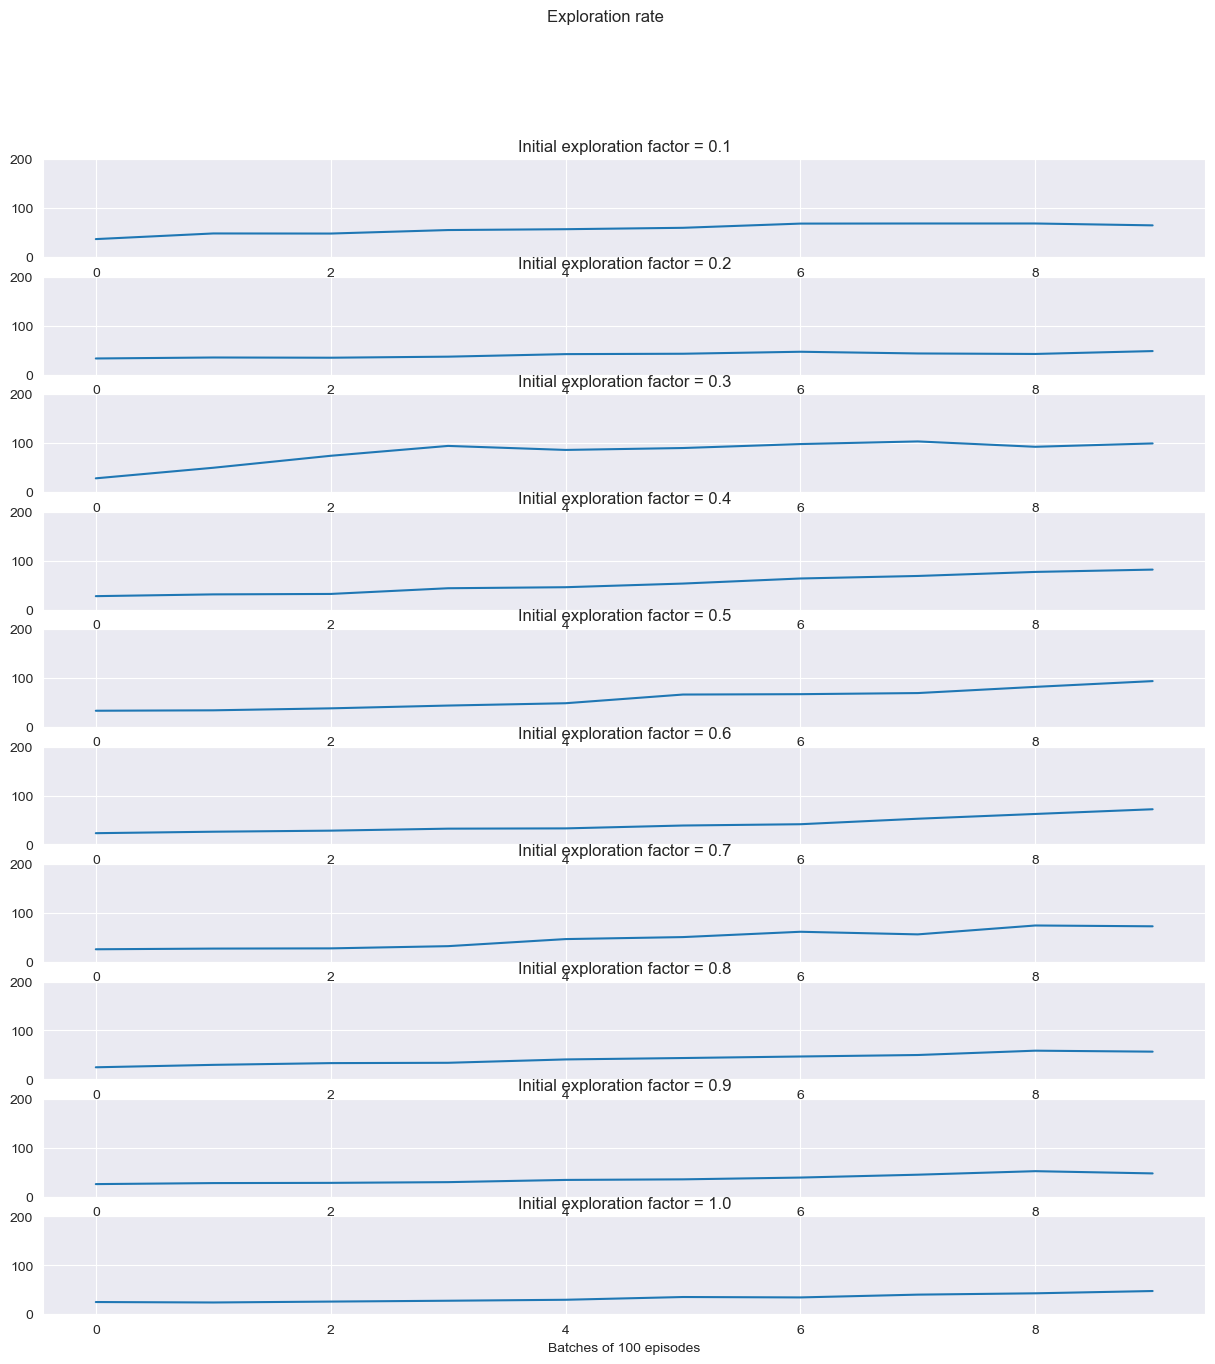

In [21]:
if __name__ == "__main__":
    PATH_SAVE= "save_models/"
    NB_EPISODES = 1000
    state_dim = 4 # 4 states : position, velocity, angle, angular velocity

    to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    timeBegin = time.time()
    with multiprocessing.pool.ThreadPool(processes=8) as pool:
        f = lambda n : evaluate_model(3, NB_EPISODES, exploration=n, tqdm_disable=True)
        results = pool.map(f, to_try)
    timeEnd = time.time()
    print(timeEnd - timeBegin)
    plot_exploration_rate(results, to_try)

Performance after the first 1000 episodes

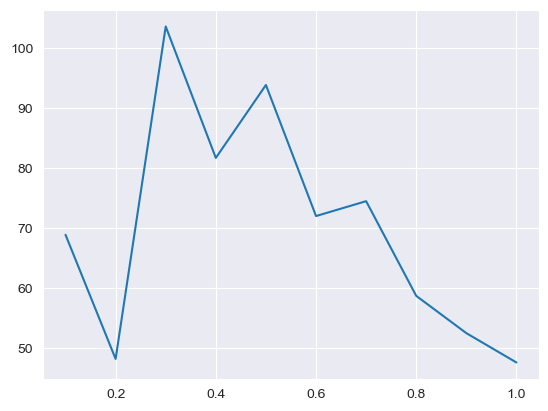

In [32]:
result = [np.max(results[i][2][-10:]) for i in range(len(results))]
plt.plot(to_try, result)

A longuer test (with 10 000 episodes). It seems like 0.5 is the best.
But concidering that the result is the best among the last 10 means of 100 episodes and after analysing the following graph, 0.6 seems to be a good setting for the hyperparameter too.

100%|██████████| 10/10 [04:04<00:00, 24.42s/it]

244.1688528060913


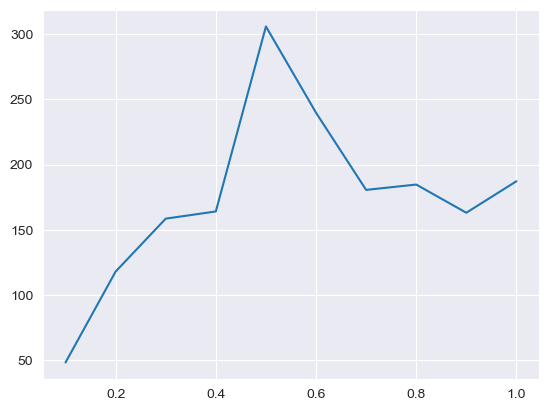

In [39]:
# test the exploration rate for NB_EPISODES episodes to determine the best one
# As a reminder : evaluate_model outputs a tuple (q_table, scores, steps_history, exploration_list)

if __name__ == "__main__":
    to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    NB_EPISODES = 10_000
    plot_list = []
    timeBegin = time.time()
    for coeff in tqdm(to_try):
        rslt = evaluate_model(3, NB_EPISODES, exploration=coeff, tqdm_disable=True)
        plot_list.append(rslt)
    timeEnd = time.time()
    print(timeEnd - timeBegin)
    result = [np.max(plot_list[i][2][-10:]) for i in range(len(results))]
    plt.plot(to_try, result)
    exploration_at_the_end = [plot_list[i][3][-1] for i in range(len(results))]

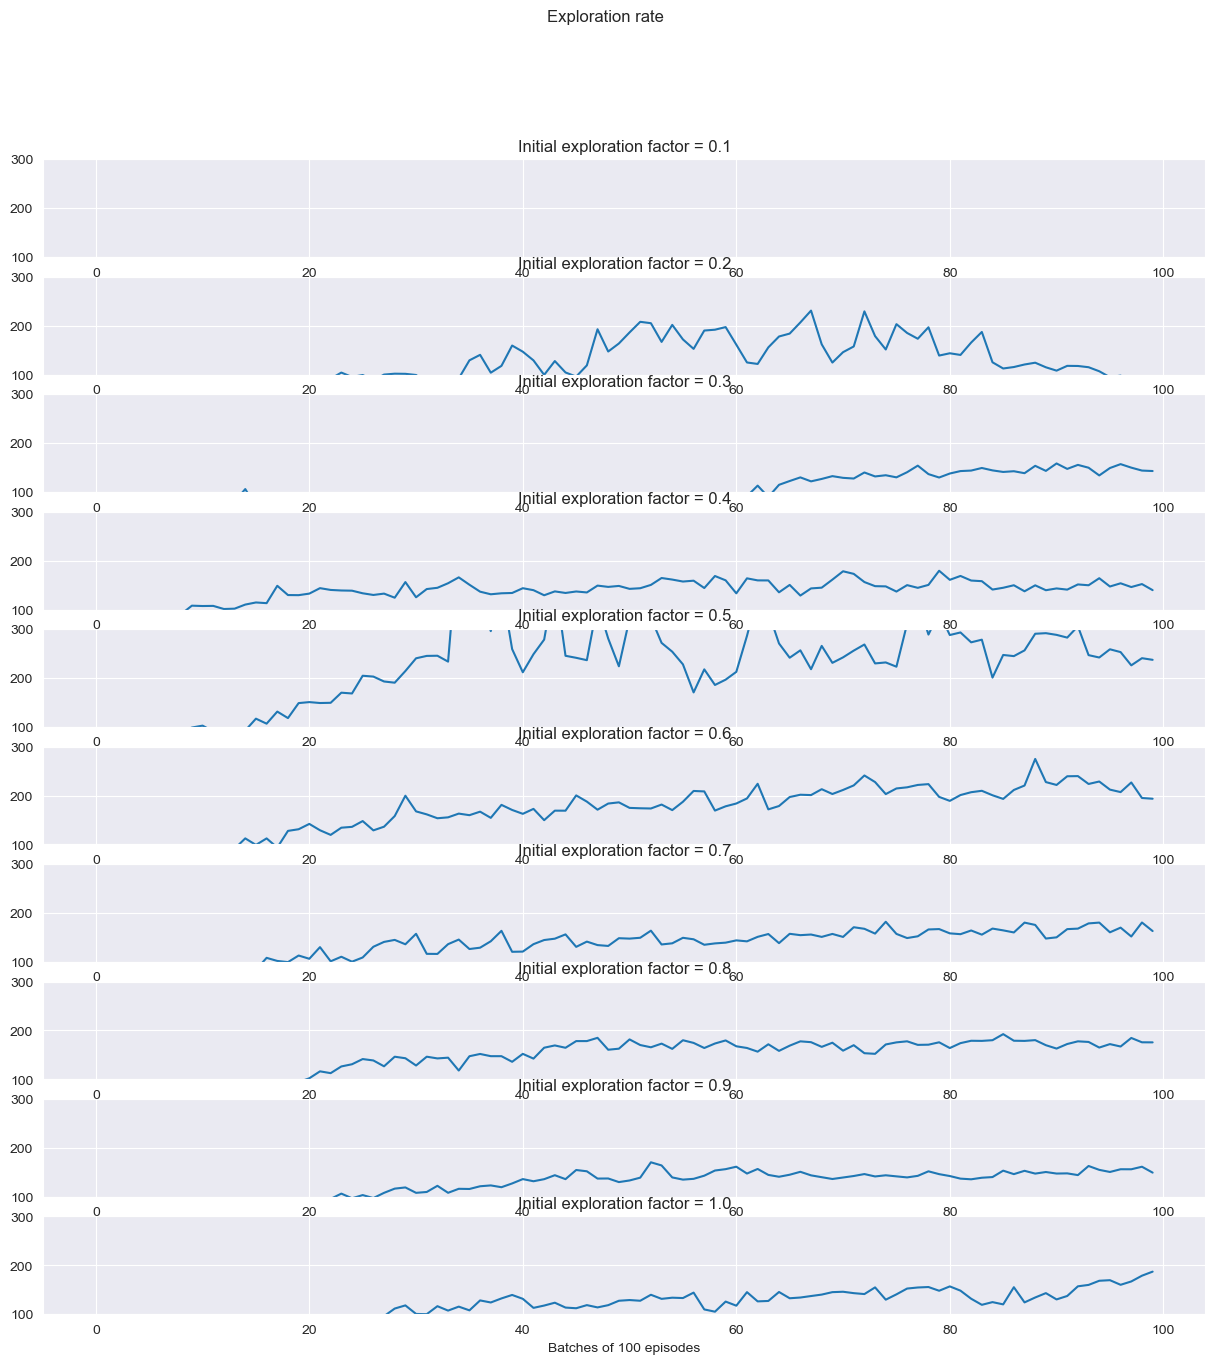

In [42]:
plot_exploration_rate(plot_list, to_try)

The following test takes into account the initial exploration rate and the decay. Both hyperparamters are important in the process of exploring the environment to acquire knowledge

In [ ]:
if __name__ == "__main__":
    # As a reminder : evaluate_model outputs a tuple (q_table, scores, steps_history, exploration_list)
    # Furthermore, MIN_EXPLORE is set to 0.05
    PATH_SAVE = "save_models/"
    initials = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    decays = np.array([0.9,0.99,0.995,0.999,0.9995,0.9999,0.99995])
    NB_EPISODES = 10_000
    results = np.zeros(shape=(len(initials), len(decays))).tolist()
    timeBegin = time.time()
    for i in tqdm(range(len(initials))):
        for j in range(len(decays)):
            rslt = evaluate_model(3, NB_EPISODES, exploration=initials[i], exploration_decay=decays[j], tqdm_disable=True)
            results[i][j] = rslt[2][-20:]
    timeEnd = time.time()
    print(f"Processed time is {timeEnd - timeBegin} s")

Blue : mean is under 195
Green : it is above 195
Red : it is the best pair of hyperparameters

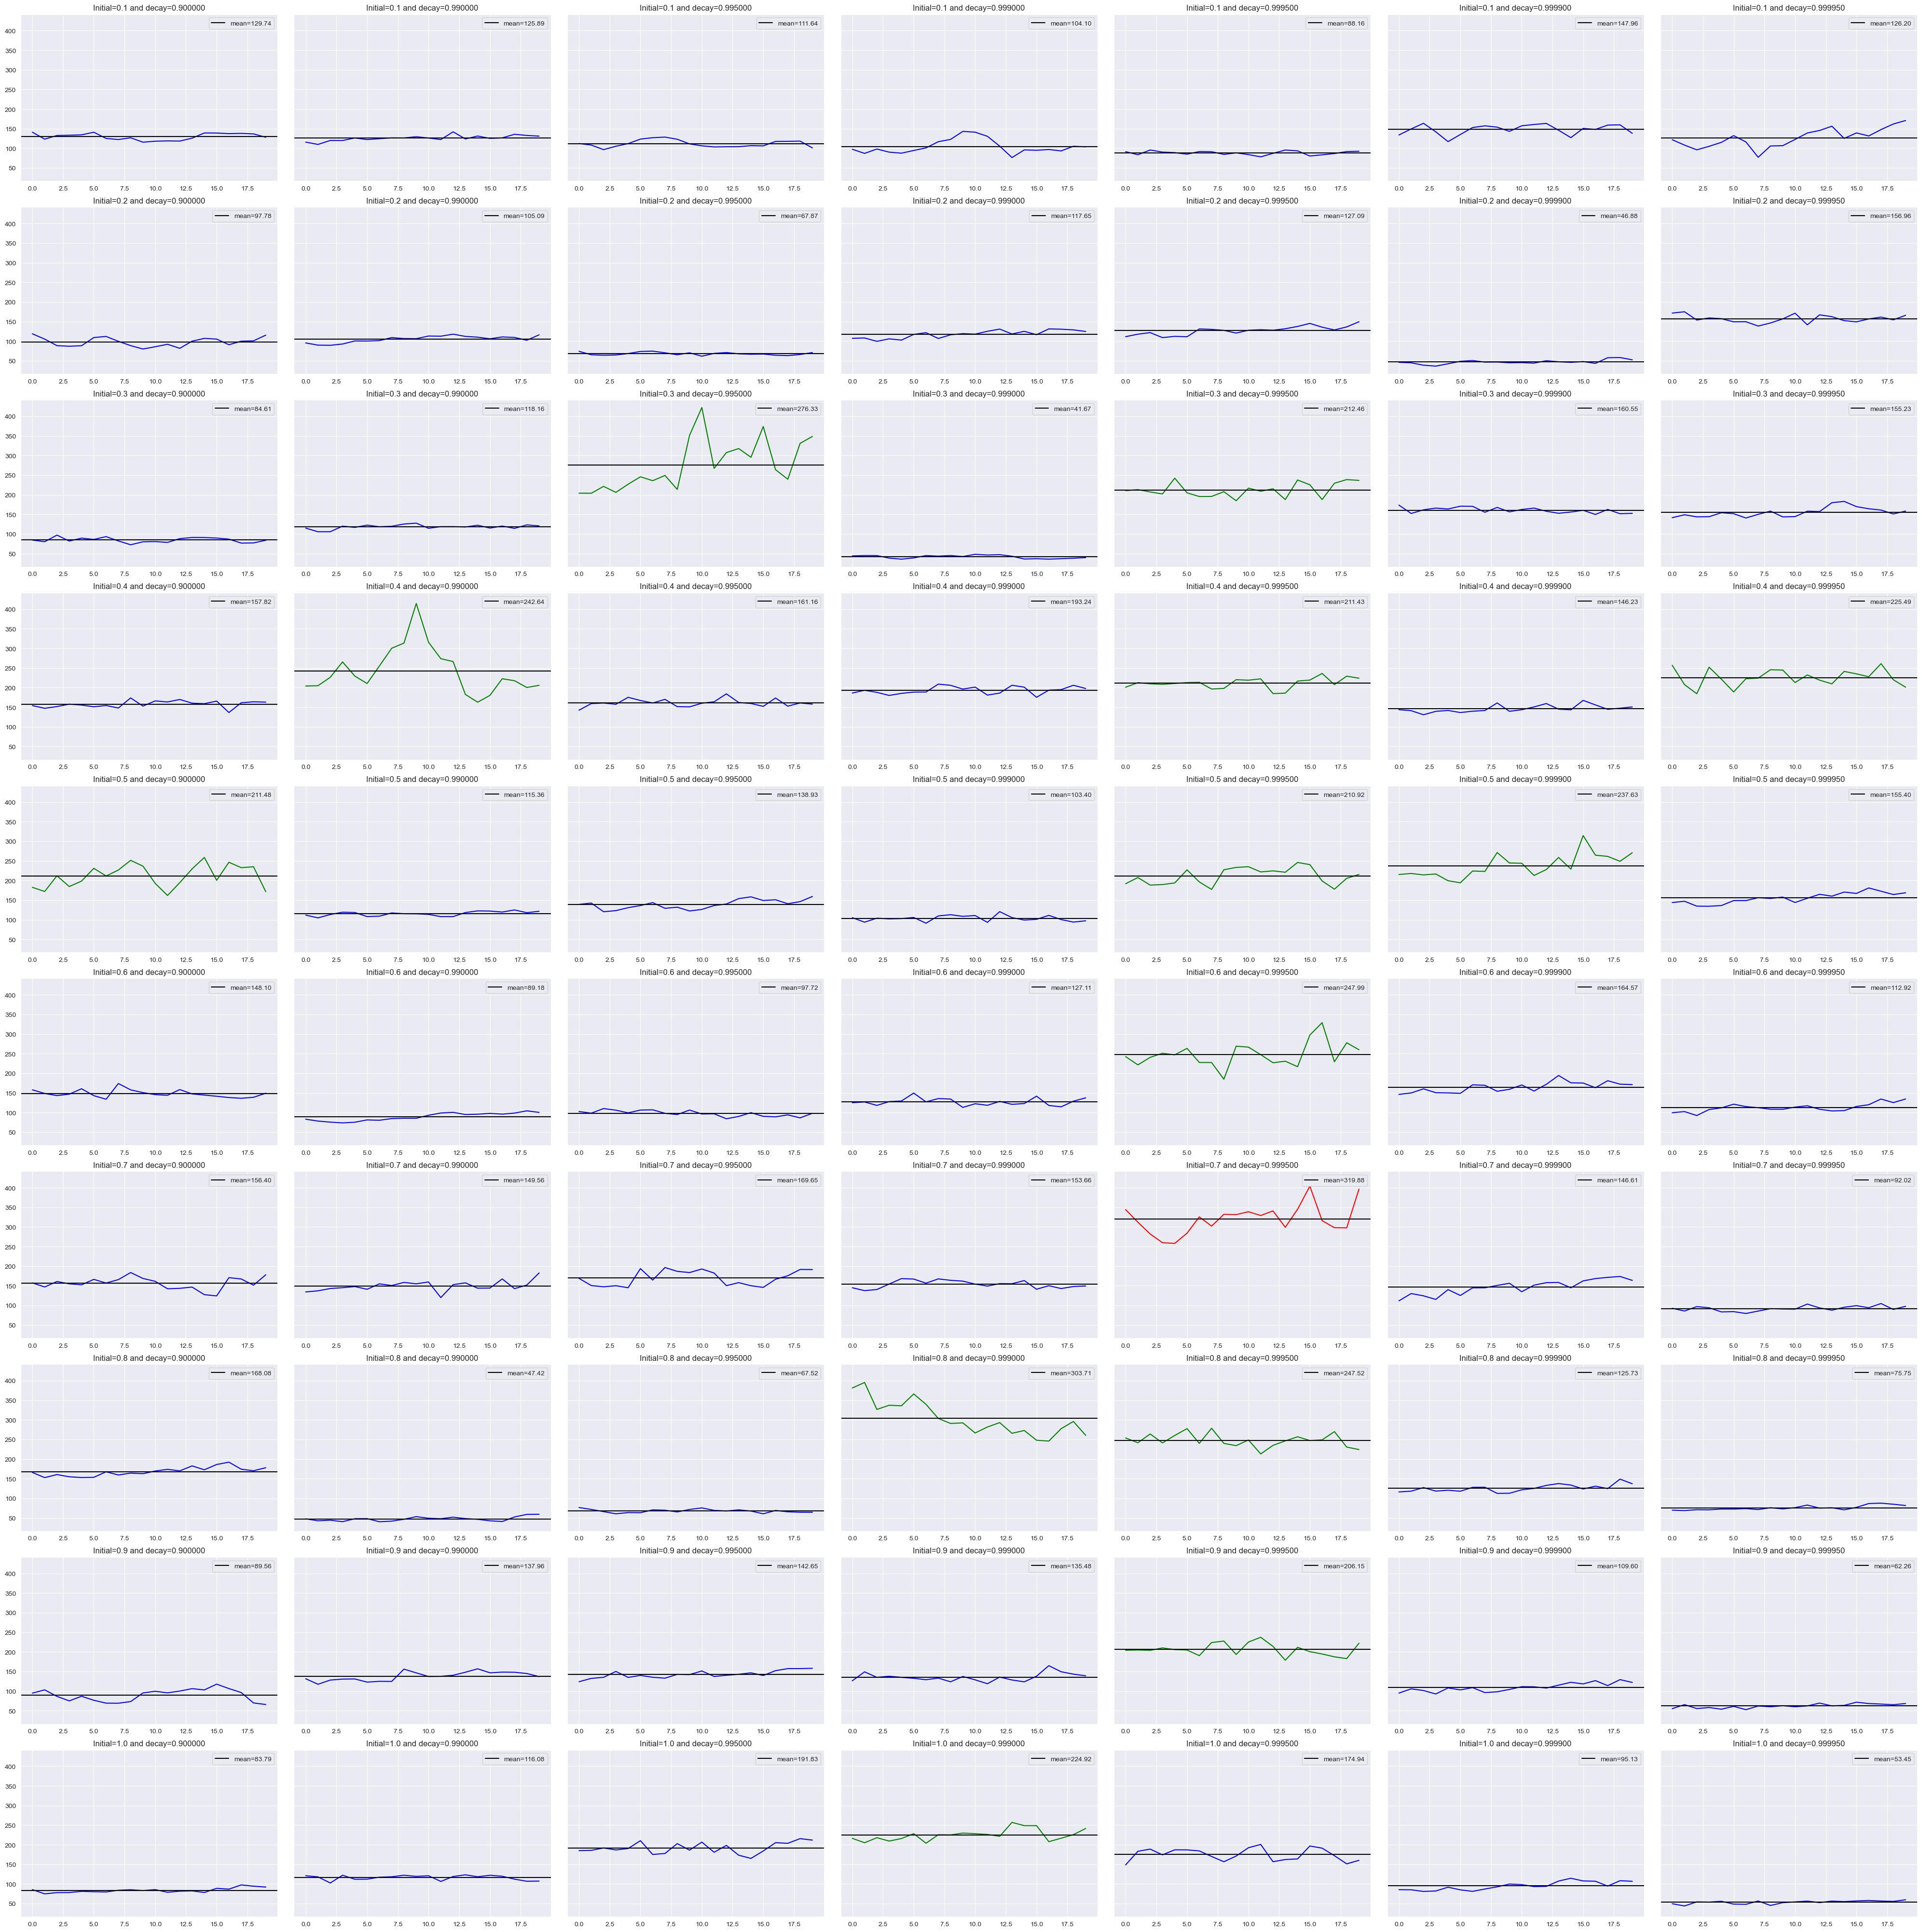

In [122]:
    fig, axs =plt.subplots(len(initials), len(decays), figsize=(40,40),sharey='all')
    fig.tight_layout(h_pad=2)

    #keep the mean of the last 20 episodes
    mean_results = np.array([[np.mean(results[i][j]) for i in range(len(initials))] for j in range(len(decays))]).T
    #Find the indexes of the maximum 
    max_index = np.unravel_index(np.argmax(mean_results), mean_results.shape)

    for i in range(len(initials)):
        for j in range(len(decays)):
            if mean_results[i,j] > 195:
                if (i,j) == max_index:
                    axs[i,j].plot(results[i][j], color='r')
                else:
                    axs[i,j].plot(results[i][j], color='g')
            else:
                axs[i,j].plot(results[i][j], color='b')
            axs[i,j].set_title(f"Initial={initials[i]} and decay={decays[j]:.6f}") # keep only 2 decimals
            axs[i,j].axhline(y=mean_results[i,j], color='black', linestyle='-', label=f"mean={mean_results[i,j]:.2f}")
            axs[i,j].legend(loc='upper right')

    #plt.show()

    #save the image
    fig.savefig(PATH_SAVE+"results_exploration_improved.png")

# Final result with the best hyperparameters

In [24]:
action_dim = 3
results = evaluate_model(action_dim, 10_000, exploration=0.7, exploration_decay=0.9995, tqdm_disable=False)

100%|██████████| 10000/10000 [00:40<00:00, 246.67it/s]


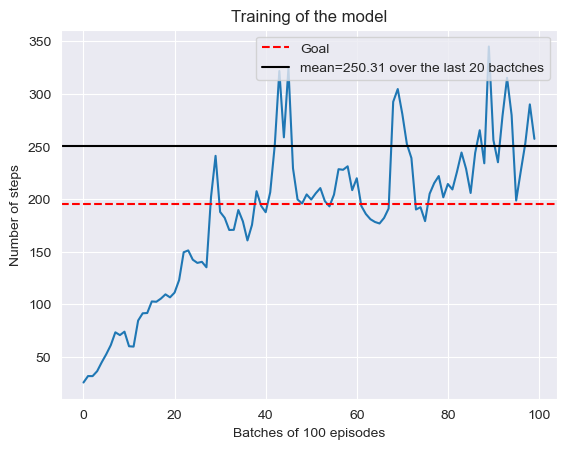

In [31]:
plt.plot(results[2])
plt.title(f"Training of the model")
plt.xlabel("Batches of 100 episodes")
plt.ylabel("Number of steps")
plt.axhline(y=195, color='r', linestyle='--', label="Goal")
plt.axhline(y=np.mean(results[2][-20:]), color='black', linestyle='-', label=f"mean={np.mean(results[2][-20:]):.2f} over the last 20 bactches")
plt.legend(loc='upper right')
plt.show()